In [1]:
!nvidia-smi

Sat May  4 14:58:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |   1854MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#https://drive.google.com/open?id=1zglOX-AkDkXV3SAiUcQEm0gssYF3FrVZ

download = drive.CreateFile({'id': '1zglOX-AkDkXV3SAiUcQEm0gssYF3FrVZ'})
download.GetContentFile('Flickr8k.zip')

In [3]:
!unzip Flickr8k.zip

Archive:  Flickr8k.zip
replace Flickr8k/Flickr8k_text/CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Flickr8k/Flickr8k_text/CrowdFlowerAnnotations.txt  
  inflating: Flickr8k/Flickr8k_text/ExpertAnnotations.txt  
  inflating: Flickr8k/Flickr8k_text/Flickr8k.lemma.token.txt  
  inflating: Flickr8k/Flickr8k_text/Flickr8k.token.txt  
  inflating: Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt  
  inflating: Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt  
  inflating: Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt  
  inflating: Flickr8k/Flickr8k_text/readme.txt  
  inflating: Flickr8k/Flicker8k_Dataset/1007320043_627395c3d8.jpg  
  inflating: Flickr8k/Flicker8k_Dataset/1019604187_d087bf9a5f.jpg  
  inflating: Flickr8k/Flicker8k_Dataset/1056359656_662cee0814.jpg  
  inflating: Flickr8k/Flicker8k_Dataset/1057251835_6ded4ada9c.jpg  
  inflating: Flickr8k/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg  
  inflating: Flickr8k/Flicker8k_Dataset/1067180831_a59dc

# VGG16Fasttext

In [0]:
#https://drive.google.com/open?id=1IXGOW6ZS1jTb2BrR04OI4bSQ_DSgIiYf
download = drive.CreateFile({'id': '1IXGOW6ZS1jTb2BrR04OI4bSQ_DSgIiYf'})
download.GetContentFile('model-ep004-loss3.440-val_loss3.771.h5')

#https://drive.google.com/open?id=1qSBILpQ2hlLvREjAImQkgd6MOFBNPtDg
download = drive.CreateFile({'id': '1qSBILpQ2hlLvREjAImQkgd6MOFBNPtDg'})
download.GetContentFile('features7.pkl')

#https://drive.google.com/open?id=1t1wrYsvyQFAMyT2brQDLlNqjtckRU1J1
download = drive.CreateFile({'id': '1t1wrYsvyQFAMyT2brQDLlNqjtckRU1J1'})
download.GetContentFile('descriptions7.txt')

#https://drive.google.com/open?id=1uONcaNSqxH56ViO5K6CGUHSH0qIWmGcv
download = drive.CreateFile({'id': '1uONcaNSqxH56ViO5K6CGUHSH0qIWmGcv'})
download.GetContentFile('tokenizer7.pkl')


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [6]:
import pickle
import numpy as np

def load_doc(fname):
  fp=open(fname,'r')
  txt=fp.read()
  fp.close()
  return txt

fname='Flickr8k/Flickr8k_text/Flickr8k.token.txt'
doc=load_doc(fname)

def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  rd={}
  actual,predicted=list(),list()
  for key,desc_list in descriptions.items():
    yhat=generate_desc(model,tokenizer,photos[key],max_len)
    
    references=[d.split() for d in desc_list]
    
    rd[key]=(references,yhat.split())
  
    actual.append(references)
    predicted.append(yhat.split())
    
    
  return actual,predicted,rd

def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None
  
def generate_desc(model,tokenizer,photo,max_len):
  in_text='startseq'
  
  for i in range(max_len):
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    
    sequence=pad_sequences([sequence],maxlen=max_len)
    
    yhat=model.predict([photo,sequence],verbose=0)
    yhat=np.argmax(yhat)
    
    word=word_for_id(yhat,tokenizer)
    
    if word is None:
      break
      
    in_text += ' '+word
    
    if word=='endseq':
      break
      
  return in_text

def load_set(fname):
  doc=load_doc(fname)
  dataset=list()
  for line in doc.split('\n'):
    if len(line)<1:
      continue
    identifier=line.split('.')[0]
    dataset.append(identifier)

  return dataset,set(dataset)

def load_clean_descriptions(fname,dataset):
  doc=load_doc(fname)
  descriptions = dict()
  for line in doc.split('\n'):
    tokens=line.split()
    img_id,img_desc=tokens[0],tokens[1:]
    if img_id in dataset:
      if img_id not in descriptions:
        descriptions[img_id]=list()
      
      desc='startseq ' + ' '.join(img_desc) + ' endseq'
      #print(img_id,img_desc)
      descriptions[img_id].append(desc)
      #print(img_id,descriptions[img_id])
  
  return descriptions

def load_photo_features(fname,dataset):
  all_features=pickle.load(open(fname,'rb'))
  features={k:all_features[k] for k in dataset}
  return features

fname='Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
testlist,test=load_set(fname)
print(len(testlist),len(test))
test_descriptions=load_clean_descriptions('descriptions7.txt',testlist)
print(len(test_descriptions))
test_features=load_photo_features('features7.pkl',testlist)
print(len(test_features))

1000 1000
1000
1000


In [7]:
len(testlist)

1000

In [8]:
import numpy as np
import pandas as pd
import cv2
import time
import os
import matplotlib.pyplot as plt
import pickle
import string

from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input

#from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
#import shutil #dont use shutil it deletes files
from collections import Counter


Using TensorFlow backend.


In [0]:
tokenizer=pickle.load(open('tokenizer7.pkl','rb'))

In [0]:
max_len=34

In [11]:
# test set
start=time.time()
VGG16Fasttext=load_model('model-ep004-loss3.440-val_loss3.771.h5')
actual,predicted,rd_test=evaluate_model(VGG16Fasttext,test_descriptions,test_features,tokenizer,max_len)
end=time.time()
print(end-start)
print('BLEU - 1 : %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print('BLEU - 2 : %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
print('BLEU - 3 : %f' % corpus_bleu(actual,predicted,weights=(0.3,0.3,0.3,0)))
print('BLEU - 4 : %f' % corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))
print(len(actual),len(predicted))
pickle.dump(actual,open('actual.pkl','wb'))
pickle.dump(predicted,open('predicted.pkl','wb'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
218.87772464752197
BLEU - 1 : 0.527234
BLEU - 2 : 0.276132
BLEU - 3 : 0.186770
BLEU - 4 : 0.082055
1000 1000


In [12]:
rd_test

{'1056338697_4f7d7ce270': ([['startseq',
    'blond',
    'woman',
    'in',
    'blue',
    'shirt',
    'appears',
    'to',
    'wait',
    'for',
    'ride',
    'endseq'],
   ['startseq',
    'blond',
    'woman',
    'is',
    'on',
    'the',
    'street',
    'hailing',
    'taxi',
    'endseq'],
   ['startseq',
    'woman',
    'is',
    'signaling',
    'is',
    'to',
    'traffic',
    'as',
    'seen',
    'from',
    'behind',
    'endseq'],
   ['startseq',
    'woman',
    'with',
    'blonde',
    'hair',
    'wearing',
    'blue',
    'tube',
    'top',
    'is',
    'waving',
    'on',
    'the',
    'side',
    'of',
    'the',
    'street',
    'endseq'],
   ['startseq',
    'the',
    'woman',
    'in',
    'the',
    'blue',
    'dress',
    'is',
    'holding',
    'out',
    'her',
    'arm',
    'at',
    'oncoming',
    'traffic',
    'endseq']],
  ['startseq',
   'two',
   'girls',
   'are',
   'playing',
   'in',
   'the',
   'park',
   'endseq']),
 '1064908

In [13]:
testlist[7]

'256085101_2c2617c5d0'

In [14]:
testlist[126]

'1122944218_8eb3607403'

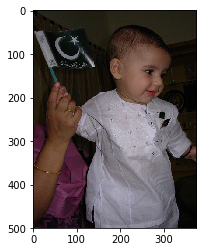

In [15]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('Flickr8k/Flicker8k_Dataset/1122944218_8eb3607403.jpg')
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [17]:
rd_test['1122944218_8eb3607403']

([['startseq',
   'baby',
   'in',
   'white',
   'garment',
   'holds',
   'flag',
   'with',
   'crescent',
   'moon',
   'and',
   'star',
   'endseq'],
  ['startseq',
   'baby',
   'is',
   'holding',
   'small',
   'black',
   'flag',
   'with',
   'moon',
   'and',
   'star',
   'on',
   'it',
   'endseq'],
  ['startseq',
   'baby',
   'wearing',
   'white',
   'gown',
   'waves',
   'muslim',
   'flag',
   'endseq'],
  ['startseq',
   'little',
   'toddler',
   'dressed',
   'in',
   'white',
   'is',
   'smiling',
   'while',
   'lady',
   'helps',
   'him',
   'wave',
   'flag',
   'endseq'],
  ['startseq',
   'baby',
   'in',
   'white',
   'outfit',
   'holding',
   'black',
   'and',
   'white',
   'flag',
   'endseq']],
 ['startseq', 'little', 'boy', 'is', 'playing', 'in', 'the', 'park', 'endseq'])

In [0]:
pickle.dump(rd_test,open('rd_VGG16FT_test.pkl','wb'))

In [0]:
uploadId = '1Hw09omY9-FIa_Z4o0PswO-Xx3Gb6DHU3'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'rd_VGG16FT_test.pkl'})
uploaded.SetContentFile('rd_VGG16FT_test.pkl')
uploaded.Upload()

In [21]:
len(rd_test)

1000